In [2]:
!pip install torch torchvision matplotlib numpy requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [1]:
# --- Importaciones del sistema y configuración de la ruta ---
import sys
import os
import warnings
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Añadir el directorio raíz del proyecto al path
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
print(f"Project root añadido al path: {PROJECT_ROOT}")

# --- Importaciones del framework de ataque ---
from models.pytorch import PyTorchModel
from attacks.carlini_wagner import CarliniWagnerL2Attack
from criteria import Misclassification, TargetClass
from distances import MeanSquaredDistance as MSE
from adversarial import Adversarial

# Ignorar advertencias
warnings.filterwarnings("ignore", category=UserWarning)

Project root añadido al path: /


In [7]:
# --- Celda 2 o 3

import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# 1. Definir la arquitectura de la red (siempre es necesario para instanciar el modelo)
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(7*7*64, 128) # 28x28 -> MaxPool -> 14x14 -> MaxPool -> 7x7
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 7*7*64)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 2. Definir la ruta del modelo y el dispositivo
model_save_path = "model_weights/mnist_cnn_trained.pth"
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# 3. Crear una instancia del modelo
model = MNIST_CNN().to(device)

# 4. Comprobar si el modelo pre-entrenado existe
if os.path.exists(model_save_path):
    # --- Si existe, cargar los pesos ---
    print(f"Cargando modelo pre-entrenado desde: {model_save_path}")
    # Cargamos el diccionario de estado en la instancia del modelo
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    print("Modelo cargado exitosamente.")

else:
    # --- Si no existe, entrenarlo ---
    print(f"No se encontró el modelo en '{model_save_path}'. Iniciando entrenamiento...")

    # Preparar los datos de MNIST
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) # Normalización estándar para MNIST
    ])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Configurar optimizador y función de pérdida
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion_loss = nn.CrossEntropyLoss()
    epochs = 5 # 5 épocas son suficientes para una buena precisión

    # Bucle de entrenamiento
    model.train() # Poner el modelo en modo de entrenamiento
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
             data, target = data.to(device), target.to(device)
             optimizer.zero_grad()
             output = model(data)
             loss = criterion_loss(output, target)
             loss.backward()
             optimizer.step()
             if batch_idx % 200 == 0:
                print(f"Epoch: {epoch+1}/{epochs} | Batch: {batch_idx*len(data)}/{len(train_loader.dataset)} | Loss: {loss.item():.4f}")

    print("Entrenamiento finalizado.")

    # Guardar el modelo recién entrenado para futuras ejecuciones
    torch.save(model.state_dict(), model_save_path)
    print(f"Modelo entrenado y guardado en: {model_save_path}")

# 5. Poner el modelo en modo de evaluación (ya sea cargado o recién entrenado)
model.eval()

# (Opcional pero recomendado) Evaluar la precisión para confirmar que se cargó/entrenó bien
transform_eval = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_eval)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
accuracy = 100 * correct / total
print(f"\nPrecisión del modelo en el set de prueba: {accuracy:.2f}%")

Cargando modelo pre-entrenado desde: model_weights/mnist_cnn_trained.pth
Modelo cargado exitosamente.

Precisión del modelo en el set de prueba: 99.43%


In [3]:
# --- Celda 2: Definir, Cargar y Entrenar el Modelo para MNIST ---

# 1. Definir la arquitectura de la red convolucional
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(7*7*64, 128) # 28x28 -> 14x14 -> 7x7
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 7*7*64)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 2. Preparar los datos de MNIST
import torchvision.datasets as datasets
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # Normalización estándar para MNIST
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

# 3. Bucle de Entrenamiento
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = MNIST_CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion_loss = nn.CrossEntropyLoss()
epochs = 20 # 5 épocas son suficientes para una buena precisión

print(f"Iniciando entrenamiento en el dispositivo: {device}")
for epoch in range(epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            print(f"Epoch: {epoch+1}/{epochs} | Batch: {batch_idx*len(data)}/{len(train_loader.dataset)} | Loss: {loss.item():.4f}")

print("Entrenamiento finalizado.")

# 4. Evaluar el modelo entrenado
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

accuracy = 100 * correct / total
print(f"\nPrecisión del modelo en el set de prueba: {accuracy:.4f}%")

Iniciando entrenamiento en el dispositivo: cuda:0
Epoch: 1/20 | Batch: 0/60000 | Loss: 2.2906
Epoch: 1/20 | Batch: 12800/60000 | Loss: 0.1995
Epoch: 1/20 | Batch: 25600/60000 | Loss: 0.1076
Epoch: 1/20 | Batch: 38400/60000 | Loss: 0.1063
Epoch: 1/20 | Batch: 51200/60000 | Loss: 0.1266
Epoch: 2/20 | Batch: 0/60000 | Loss: 0.1375
Epoch: 2/20 | Batch: 12800/60000 | Loss: 0.0777
Epoch: 2/20 | Batch: 25600/60000 | Loss: 0.0194
Epoch: 2/20 | Batch: 38400/60000 | Loss: 0.0426
Epoch: 2/20 | Batch: 51200/60000 | Loss: 0.0368
Epoch: 3/20 | Batch: 0/60000 | Loss: 0.0454
Epoch: 3/20 | Batch: 12800/60000 | Loss: 0.2263
Epoch: 3/20 | Batch: 25600/60000 | Loss: 0.1260
Epoch: 3/20 | Batch: 38400/60000 | Loss: 0.1180
Epoch: 3/20 | Batch: 51200/60000 | Loss: 0.0875
Epoch: 4/20 | Batch: 0/60000 | Loss: 0.0137
Epoch: 4/20 | Batch: 12800/60000 | Loss: 0.0043
Epoch: 4/20 | Batch: 25600/60000 | Loss: 0.0361
Epoch: 4/20 | Batch: 38400/60000 | Loss: 0.0904
Epoch: 4/20 | Batch: 51200/60000 | Loss: 0.0480
Epoch:

In [4]:
# 5. Guardar el estado del modelo entrenado
model_save_path = "mnist_cnn_trained.pth"
torch.save(model.state_dict(), model_save_path)
print(f"\nModelo entrenado guardado en: {model_save_path}")


Modelo entrenado guardado en: mnist_cnn_trained.pth


Límites precisos calculados para el modelo: (-0.424212917883804, 2.82148653034729)

Imagen de ejemplo seleccionada:
Dimensiones de la imagen NumPy: (28, 28, 1)
Etiqueta original (ground truth): 8
Predicción del modelo sobre la imagen original: 8


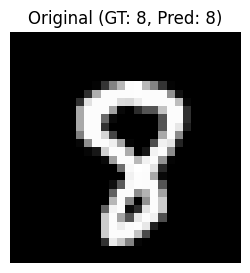

In [9]:
# --- Celda 3: Wrappear el Modelo y Seleccionar un Ejemplo ---

# 1. Wrappear el modelo entrenado para nuestro framework
mean = 0.1307
std = 0.3081
min_val = (0 - mean) / std
max_val = (1 - mean) / std
precise_bounds = (min_val, max_val)

print(f"Límites precisos calculados para el modelo: {precise_bounds}")

fmodel = PyTorchModel(
    model,
    bounds=precise_bounds, # Usamos los bounds precisos (sin épsilon)
    num_classes=10,
    channel_axis=1,
    preprocessing=(0, 1),
    device=device
)

# 2. Seleccionar una imagen de prueba que el modelo clasifique correctamente
image_np, label = None, -1
original_pred_label = -1

single_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
for data, target in single_test_loader:
    current_image_np = data.squeeze(0).permute(1, 2, 0).cpu().numpy()
    current_label = target.item()
    prediction = np.argmax(fmodel.predictions(current_image_np))
    if prediction == current_label:
        image_np = current_image_np
        label = current_label
        original_pred_label = prediction
        break

if image_np is None:
    raise RuntimeError("No se encontró ninguna imagen clasificada correctamente para el ataque.")

print(f"\nImagen de ejemplo seleccionada:")
print(f"Dimensiones de la imagen NumPy: {image_np.shape}")
print(f"Etiqueta original (ground truth): {label}")
print(f"Predicción del modelo sobre la imagen original: {original_pred_label}")

# 3. Visualizar la imagen de ejemplo
vis_image = np.clip(image_np * std + mean, 0, 1)
plt.figure(figsize=(3, 3))
plt.imshow(vis_image.squeeze(), cmap='gray')
plt.title(f"Original (GT: {label}, Pred: {original_pred_label})")
plt.axis('off')
plt.show()

In [21]:
# --- Celda 4: Configurar y Ejecutar el Ataque C&W L2 ---

# 1. Crear el objeto Adversarial
# Usaremos Misclassification para que el ataque intente cambiar la etiqueta a CUALQUIER otra.
# Si quisieras un ataque dirigido (ej. forzar que un 7 sea un 1), usarías:
# criterion = TargetClass(target_label)
criterion = Misclassification()
distance = MSE # El ataque C&W L2 minimiza la distancia L2 (representada por MSE)

adversarial = Adversarial(
    fmodel,
    criterion,
    image_np,
    label,
    distance=distance
)

# 2. Inicializar y ejecutar el ataque
# Para MNIST, los parámetros pueden ser más bajos y aún así obtener buenos resultados.
print("Iniciando ataque de Carlini & Wagner L2...")
attack = CarliniWagnerL2Attack()
attack(adversarial, binary_search_steps=10, max_iterations=1000, confidence=0, learning_rate=1e-2)
print("Ataque finalizado.")

Iniciando ataque de Carlini & Wagner L2...

Búsqueda binaria paso 1/10, const = 1.0e-03
  Iteración 100/1000, Pérdida: 0.0358, Mejor L2: inf
  Iteración 200/1000, Pérdida: 0.0358, Mejor L2: inf
  Iteración 300/1000, Pérdida: 0.0358, Mejor L2: inf
  Iteración 400/1000, Pérdida: 0.0358, Mejor L2: inf
  Iteración 500/1000, Pérdida: 0.0358, Mejor L2: inf
  Iteración 600/1000, Pérdida: 0.0358, Mejor L2: inf
  Iteración 700/1000, Pérdida: 0.0358, Mejor L2: inf
  Iteración 800/1000, Pérdida: 0.0358, Mejor L2: inf
  Iteración 900/1000, Pérdida: 0.0358, Mejor L2: inf
  Iteración 1000/1000, Pérdida: 0.0358, Mejor L2: inf
  Fallo para const=1.0e-03. Nuevo límite inferior: 1.0e-03

Búsqueda binaria paso 2/10, const = 1.0e-02
  Iteración 100/1000, Pérdida: 0.3562, Mejor L2: inf
  Iteración 200/1000, Pérdida: 0.3559, Mejor L2: inf
  Iteración 300/1000, Pérdida: 0.3555, Mejor L2: inf
  Iteración 400/1000, Pérdida: 0.3555, Mejor L2: inf
  Iteración 500/1000, Pérdida: 0.3555, Mejor L2: inf
  Iteración 


¡Ataque exitoso!
Etiqueta Real: 8
Predicción Original: 8
Predicción Adversarial: 9


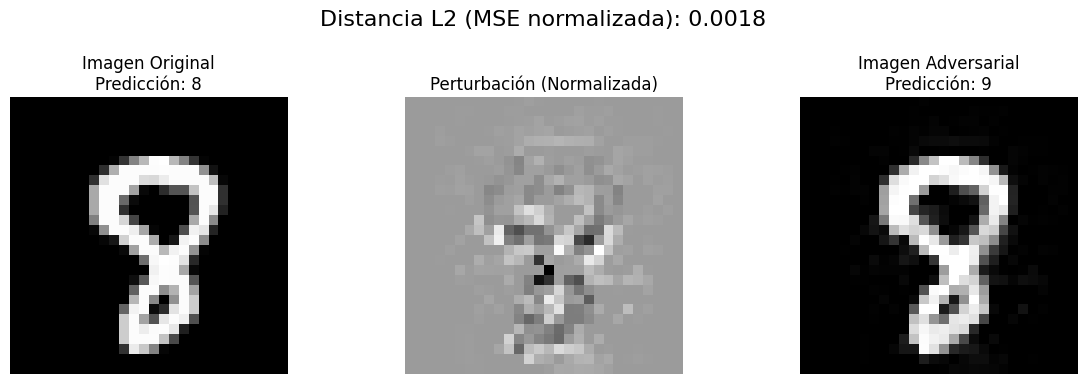

In [22]:
# --- Celda 5: Analizar y Visualizar Resultados (con des-normalización) ---

def show_mnist_results(original_np, adversarial_np, original_label, adversarial_label, distance):
    """Función mejorada para visualizar los resultados de MNIST."""
    if adversarial_np is None:
        print("El ataque no encontró un ejemplo adversarial.")
        return

    # Des-normalizar para una correcta visualización
    # Estos son los valores estándar de normalización para MNIST
    mean = 0.1307
    std = 0.3081

    original_vis = np.clip(original_np * std + mean, 0, 1)
    adversarial_vis = np.clip(adversarial_np * std + mean, 0, 1)

    # La perturbación es la diferencia. La amplificamos para que sea visible.
    perturbation = adversarial_vis - original_vis
    # Normalizamos la perturbación para que sea visible en escala de grises
    # Añadimos un pequeño épsilon para evitar la división por cero si no hay perturbación
    perturbation_vis = (perturbation - perturbation.min()) / (perturbation.max() - perturbation.min() + 1e-6)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Imagen Original
    axes[0].imshow(original_vis.squeeze(), cmap='gray')
    axes[0].set_title(f"Imagen Original\nPredicción: {original_label}")
    axes[0].axis('off')

    # Perturbación
    axes[1].imshow(perturbation_vis.squeeze(), cmap='gray')
    axes[1].set_title("Perturbación (Normalizada)")
    axes[1].axis('off')

    # Imagen Adversarial
    axes[2].imshow(adversarial_vis.squeeze(), cmap='gray')
    axes[2].set_title(f"Imagen Adversarial\nPredicción: {adversarial_label}")
    axes[2].axis('off')

    plt.suptitle(f"Distancia L2 (MSE normalizada): {distance:.4f}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Mostrar resultados ---
if adversarial.image is not None:
    print("\n¡Ataque exitoso!")
    print(f"Etiqueta Real: {adversarial.original_class}")

    # Obtenemos la predicción de la imagen original a través del fmodel
    pred_orig_label = np.argmax(fmodel.predictions(adversarial.original_image))
    print(f"Predicción Original: {pred_orig_label}")

    print(f"Predicción Adversarial: {adversarial.adversarial_class}")

    show_mnist_results(
        adversarial.original_image,
        adversarial.image,
        pred_orig_label,
        adversarial.adversarial_class,
        adversarial.distance.value
    )
else:
    print("\nEl ataque falló. No se encontró un ejemplo adversarial.")
    print("Intenta aumentar 'max_iterations' o ajustar 'learning_rate'.")